# Retro Inversian

FASTAを入力してペプチドのタイプを選択すると、L体とD体の構造を描画します。

1. FASTAを入力する
2. Linerは1、Head to Tailは2、Cystein Cyclizationは3、Disulfideは4を選択する

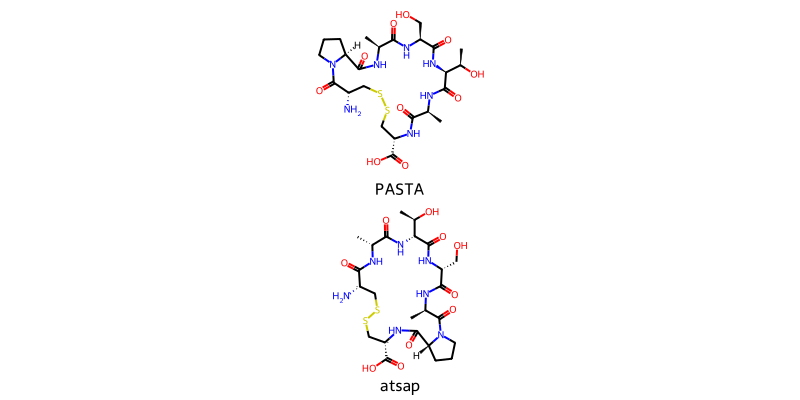

In [105]:
from rdkit import Chem
from rdkit.Chem import Draw, rdDepictor, AllChem
from rdkit.Chem.Draw import IPythonConsole
# 環状化合物をきれいに描画 https://future-chem.com/rdkit-coordgen/
rdDepictor.SetPreferCoordGen(True)

# aminoacid format
laa = 'N[C@@]([H])({X})C(=O)'
daa = 'N[C@@]({X})([H])C(=O)'

# residue dict
amino_acids = {
    'G': '[H]',
    'A': 'C',
    'V': 'C(C)C',
    'L': 'CC(C)C',
    'I': 'C(C)CC',
    'M': 'CCSC',
    'F': 'CC1=CC=CC=C1',
    'W': 'CC1=CNC2=C1C=CC=C2',
    'S': 'CO',
    'C': 'CS',
    'Y': 'CC1=CC=C(C=C1)O',
    'N': 'C(C(=O)N)',
    'Q': 'C(CC(=O)N)',
    'D': 'C(C(=O)O)',
    'E': 'C(CC(=O)O)',
    'H': 'C(C1=CNC=N1)',
    'K': 'CCCCN',
    'R': 'CCCNC(=N)N',
}

# insert variable to format
laaa = {k: laa.format(X=v) for k, v in amino_acids.items()}
daaa = {k: daa.format(X=v) for k, v in amino_acids.items()}

# add prolines and threonines
laaa['P'] = 'N1[C@@]([H])(CCC1)C(=O)'
daaa['P'] = 'N1[C@@](CCC1)([H])C(=O)'
laaa['T'] = 'N[C@@]([H])([C@]([H])(O)C)C(=O)'
daaa['T'] = 'N[C@@]([C@]([H])(O)C)([H])C(=O)'

# PepType
PepType = {
    '1' : 'Liner',
    '2' : 'Head to Tail',
    '3' : 'Cystein Cyclization',
    '4' : 'Symple Disulfide'
}


FASTA = input('FASTA?')
fasta = FASTA[::-1]
type = input('Liner:1, Head to Tail:2, Cyctein Cyclization:3, Disulfide:4')

# FASTA = 'CAWAFAAAC'
# fasta = FASTA[::-1]
# type = 'Disulfide'


l_sec = ''.join([laaa[aa] for aa in FASTA])
d_sec = ''.join([daaa[aa] for aa in fasta])

# liner
l_liner = l_sec + 'O'
d_liner = d_sec + 'O'

# Head to Tail
l_ht = 'N9' + l_sec[1:-4] + '9(=O)'
d_ht = 'N9' + d_sec[1:-4] + '9(=O)'

# Cystein Cyclization
l_cc = 'C9C(=O)' + l_sec + 'N[C@@]([H])(CS9)C(=O)N'
d_cc = 'C9C(=O)' + d_sec + 'N[C@@](CS9)([H])C(=O)N'

# Symple Disulfide
l_ds = 'N[C@@]([H])(CS9)C(=O)' + l_sec + 'N[C@@]([H])(CS9)C(=O)O'
d_ds = 'N([H])[C@@](CS9)C(=O)' + d_sec + 'N([H])[C@@](CS9)C(=O)O'

# Draw.MolToImage(Chem.MolFromSmiles(l_ht), size=(1000, 400))

if type == '2':
    l_smiles = l_ht
    d_smiles = d_ht
elif type == '3':
    l_smiles = l_cc
    d_smiles = d_cc
elif type == '4':
    l_smiles = l_ds
    d_smiles = d_ds
else:
    l_smiles = l_liner
    d_smiles = d_liner

# generate molecules
l_mol = Chem.MolFromSmiles(l_smiles)
d_mol = Chem.MolFromSmiles(d_smiles)

# output
Draw.MolsToGridImage([l_mol, d_mol], molsPerRow=1, subImgSize=(800,200), legends=[FASTA, fasta.lower()])

### 分子を重ね合わせて表示する

In [104]:
from rdkit.Chem import AllChem, rdMolAlign, Draw, rdMolDescriptors

# generate 3D conformations
Chem.AddHs(l_mol)
AllChem.EmbedMolecule(l_mol)
# AllChem.UFFOptimizeMolecule(l_mol)
Chem.AddHs(d_mol)
AllChem.EmbedMolecule(d_mol)
# AllChem.UFFOptimizeMolecule(d_mol)
mols = [l_mol, d_mol]

crippen_mols = [copy.deepcopy(m) for m in mols]
crippen_contribs = [rdMolDescriptors._CalcCrippenContribs(m) for m in crippen_mols]
crippen_o3as = [AllChem.GetCrippenO3A(prbMol=crippen_mols[i], refMol=crippen_mols[0],
                                     prbCrippenContribs=crippen_contribs[i],
                                     refCrippenContribs=crippen_contribs[0]) 
               for i in range(1, len(crippen_mols))]

view = py3Dmol.view(width=1000, height=400)
view.addModel(Chem.MolToMolBlock(crippen_mols[0]), 'sdf')
crippen_o3as[0].Align()
view.addModel(Chem.MolToMolBlock(crippen_mols[1]), 'sdf')
view.setStyle({'stick': {}})
view.zoomTo()
view.show()

[05:27:17] Molecule does not have explicit Hs. Consider calling AddHs()
[05:27:17] Molecule does not have explicit Hs. Consider calling AddHs()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### SDFの保存

L体はFASTA, D体はatsafをファイル名としてsdfを保存します。

### L体とD体両方を合わせて保存

In [91]:
# generate 3D conformations
Chem.AddHs(l_mol)
AllChem.EmbedMolecule(l_mol)
AllChem.UFFOptimizeMolecule(l_mol)
Chem.AddHs(d_mol)
AllChem.EmbedMolecule(d_mol)
AllChem.UFFOptimizeMolecule(d_mol)
mols = [l_mol, d_mol]

# SDFファイルに保存
if type==2:
    name = '_ht_dl.sdf'
elif type==3:
    name = '_cc_dl.sdf'
elif type==4:
    name = '_ds_dl.sdf'
else:
    name = '_dl.sdf'

writer = Chem.SDWriter(FASTA + name)
writer.write(l_mol)
writer.write(d_mol)
writer.close()

[05:14:45] Molecule does not have explicit Hs. Consider calling AddHs()
[05:14:45] Molecule does not have explicit Hs. Consider calling AddHs()
[05:14:45] Molecule does not have explicit Hs. Consider calling AddHs()
[05:14:45] Molecule does not have explicit Hs. Consider calling AddHs()


### L体

In [92]:
# generate 3D conformations
molecule = Chem.AddHs(l_mol)
AllChem.EmbedMolecule(l_mol)
AllChem.UFFOptimizeMolecule(l_mol)

# SDFファイルに保存
if type==2:
    name = '_ht_l.sdf'
elif type==3:
    name = '_cc_l.sdf'
elif type==4:
    name = '_ds_l.sdf'
else:
    name = '_l.sdf'
writer = Chem.SDWriter(FASTA + name)
writer.write(l_mol)
writer.close()


[05:15:45] Molecule does not have explicit Hs. Consider calling AddHs()
[05:15:45] Molecule does not have explicit Hs. Consider calling AddHs()


### D体

In [95]:
# generate 3D conformations
molecule = Chem.AddHs(d_mol)
AllChem.EmbedMolecule(d_mol)
AllChem.UFFOptimizeMolecule(d_mol)
mols = [l_mol, d_mol]
# SDFファイルに保存
if type==2:
    name = '_ht_d.sdf'
elif type==3:
    name = '_cc_d.sdf'
elif type==4:
    name = '_ds_d.sdf'
else:
    name = '_d.sdf'
writer = Chem.SDWriter(fasta.lower() + name)
writer.write(d_mol)
writer.close()

[05:17:00] Molecule does not have explicit Hs. Consider calling AddHs()
[05:17:00] Molecule does not have explicit Hs. Consider calling AddHs()


In [98]:
l_sec

'N[C@@]([H])(CS)C(=O)N[C@@]([H])(C)C(=O)N[C@@]([H])(C)C(=O)N[C@@]([H])(C)C(=O)N[C@@]([H])(CS)C(=O)'

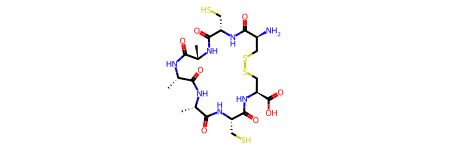

In [102]:
Chem.MolFromSmiles(
    'N[C@@]([H])(CS9)C(=O)' + l_sec + 'N[C@@]([H])(CS9)C(=O)O'
)